In [1]:
from langchain_groq import ChatGroq 
from langchain_google_genai import   GoogleGenerativeAIEmbeddings 
from langchain_huggingface import HuggingFaceEmbeddings 
from langchain_core.prompts import PromptTemplate 
from langchain_tavily import TavilySearch 
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document
from langchain.output_parsers import PydanticOutputParser
from langchain_community.document_loaders import CSVLoader 
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AIMessage, ToolMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter 
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
import faiss 

from langchain_chroma import Chroma 
from langgraph.graph import StateGraph,END 
from langchain_core.tools import tool 
import re 
from typing import TypedDict , Annotated  , List 
import operator 
import os 
from dotenv import load_dotenv 
from pydantic import BaseModel, Field  
load_dotenv() 

True

In [2]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY") 
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY") 
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
LLM_TYPE = os.getenv("LLM_TYPE")
LLM_MODEL = os.getenv("LLM_MODEL")

In [3]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [4]:
class State(TypedDict):
    messages : Annotated[list[str], operator.add]
    

In [5]:
def clean_document(document):

    content = document.page_content 

    content = re.sub(r"^:\s*\d+\s*\n", "", content) 

    content = re.sub(r"link:.*(?:\n|$)", "", content)

    content = re.sub(r'\[|\]', '', content)

    content = content.strip()

    return Document(page_content=content, metadata=document.metadata)

In [6]:
document_loader = CSVLoader(file_path="sample_food_recipes.csv", encoding="utf-8") 
documents = document_loader.load() 

In [7]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
len(embeddings.embed_query("hello world"))

d:\Anaconda\envs\agents\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [8]:
#embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
cleaned_docs = [clean_document(doc) for doc in  (documents)]

text_splitter = RecursiveCharacterTextSplitter(chunk_size= 500 , chunk_overlap=50)
cleaned_docs = text_splitter.split_documents(cleaned_docs) 

# vector_store = Chroma(
#     embedding_function=embeddings,
#     collection_name="CookDataset",
# )


In [9]:
index=faiss.IndexFlatL2(384)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    index_to_docstore_id={},
    docstore=InMemoryDocstore()
)

vector_store.add_documents(cleaned_docs)

vector_store.save_local("faiss_recepie_ivf_index")

In [6]:
@tool
def WebCrawlerTool(state:State):


    """WebCrawlerTool is a tool that performs a web search using TavilySearch and returns the results."""  

    print("inside web crawler tool")

    tool = TavilySearch(
    max_results=25,
    topic="general",
    include_answers = True, 
    include_images=True,
    search_depth = "advanced" ,
    include_related_searches = True, 
    include_snippets = True, 
    include_news = True,
    include_videos = True,
    include_websites = True, 
    include_wikipedia = True,
    include_books = True,
    include_products = True,
    include_questions = True,
    include_people = True,
    include_places = True,
    include_events = True,
    include_software = True,
    include_apps = True,
    include_scholar = True,
    include_jobs = True,
    include_facts = True,
    include_definitions = True,
    include_translations = True,
    include_summaries = True,
    include_lyrics = True,
    include_quotes = True,

    )

    search_query =state["messages"][0]

    print("inside tool " , search_query)
    results = tool.invoke(search_query) 

    return results 

In [7]:
def LLM(state:State):

    if LLM_TYPE == "GROQ":
        llm = ChatGroq(model=LLM_MODEL ,  temperature=0.1) 
    elif LLM_TYPE == "google":
        llm = ChatGoogleGenerativeAI(model=LLM_MODEL , temperature=0.1)   

    query = (
        "Using only the knowledge you've been trained on, provide a clear, comprehensive, and well-structured answer "
        "to the following question. Ensure that your explanation includes relevant context, key concepts, and any useful insights. "
        "If anything is unclear or if you need more information, use the WebCrawler tool to get more information. " 
        "Here is the question:\n\n" + state["messages"][0]
    )

    tools_list = [WebCrawlerTool]
    llm = llm.bind_tools(tools_list)


    print("Query to LLM" , query)
    result = llm.invoke(query) 

    if isinstance(result, AIMessage) and result.tool_calls:
        tool_call = result.tool_calls[0]  
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]

        #print(tool_call , tool_name , tool_args)
        
        if tool_name == "WebCrawlerTool":
            print("Tool input" , tool_args["state"])
            print("State" , State(tool_args["state"]))
            tool_output = WebCrawlerTool({"state" : tool_args["state"]})

            print("&&&&&&&&&&" , tool_output)
            tool_result_msg = ToolMessage(
                content=str(tool_output),
                tool_call_id=tool_call["id"]
            )

            final_response = llm.invoke([result, tool_result_msg])
            return {"messages": [final_response]}

    return {"messages": [result]}


In [8]:
class RecepieOutputParser(BaseModel):

    ingredients : List[str] = Field(description="List of ingredients for the recipe")
    instructions : str = Field(description="Instructions for the recipe") 

In [9]:
def RAG(state:State):

    if LLM_TYPE == "GROQ":
        llm = ChatGroq(model=LLM_MODEL, max_tokens=1000, temperature=0.1) 
    elif LLM_TYPE == "google":
        llm = ChatGoogleGenerativeAI(model=LLM_MODEL , temperature=0.1)   

    parser = PydanticOutputParser(pydantic_object=RecepieOutputParser)

    prompt = PromptTemplate(
        input_variables=["context", "question"],
        template=(
        "Using the following context, answer the question.\n\n"
        "{context}\n\n"
        "Question: {question}\n\n"
        "Format your answer as follows:\n{format_instructions}\n\n"
        "Answer:"
        ),
        partial_variables={"format_instructions": parser.get_format_instructions()},

        
    )

    query = state["messages"][0] 

    #embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    vector_store = FAISS.load_local(
    "faiss_recepie_ivf_index", embeddings, allow_dangerous_deserialization=True
    )

    retriever = vector_store.as_retriever()

    #retriever = vector_store.as_retriever()

    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | parser
    )


    result = rag_chain.invoke(query) 

    return {"messages": [result]}

In [10]:
def clean_document(document):

    content = document.page_content 

    content = re.sub(r"^:\s*\d+\s*\n", "", content) 

    content = re.sub(r"link:.*(?:\n|$)", "", content)

    content = re.sub(r'\[|\]', '', content)

    content = content.strip()

    return Document(page_content=content, metadata=document.metadata)


In [11]:
# import os 

# URI = os.getenv("MILV_END_POINT") 


# document_loader = CSVLoader(file_path="full_dataset.csv", encoding="utf-8") 
# documents = document_loader.load() 

# documents = [clean_document(doc) for doc in documents] 

In [12]:
# print(documents[0].page_content)

In [13]:
def router(state:State):
    
    last_message=state["messages"][-1]
    
    if "food recipe" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

In [14]:
class SuperVisorOutputParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [15]:
def Supervisor(state: State):
    from langchain.output_parsers import PydanticOutputParser
    from langchain_core.prompts import PromptTemplate

    question = state["messages"][-1]

    print("Supervisor received question:", question)

    parser = PydanticOutputParser(pydantic_object=SuperVisorOutputParser)
    
    if LLM_TYPE == "GROQ":
        llm = ChatGroq(model=LLM_MODEL, max_tokens=1000, temperature=0.1)
    elif LLM_TYPE == "google":
        llm = ChatGoogleGenerativeAI(model=LLM_MODEL , temperature=0.1)   


    template = """
    You are an intelligent assistant that classifies user queries into two categories: "Food Recipe" or "General".
    
    Your job is to read the user’s query, understand the context, and decide which category it belongs to, based on the following definitions:

    - **Food Recipe**: Questions asking about how to cook something, steps to prepare a meal, required ingredients, cooking tools or methods, food combinations (e.g., "What can I cook with tomatoes and cheese?"), or anything related to meal preparation or kitchen processes.

    - **General**: Any query that is not explicitly about food, cooking, or recipes. This includes current events, historical facts, science, technology, entertainment, personal opinions, advice, or anything not related to recipe preparation.

    --- 
    Instructions:
    - The "Topic" field should be either "Food Recipe" or "General".
    - Your reasoning should be 1–3 sentences explaining why the query fits the chosen category.
    - Do not add any commentary or extra explanation outside the JSON format.
    
    --- 
    User Query:
    {question}

    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | llm | parser

    print("Running Supervisor with question:", question) 
    # print("Prompt : " ,  prompt.template)
    
    response = chain.invoke({"question": question})

    print("Parsed response:", response)

    return {"messages": [response.Topic], "topic_reasoning": response.Reasoning}



In [16]:
workflow = StateGraph(State)

In [17]:
workflow.add_node("Supervisor" , Supervisor )
workflow.add_node("LLM", LLM) 
workflow.add_node("RAG", RAG)

In [18]:
workflow.set_entry_point("Supervisor")

In [19]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM"
    }
)

In [20]:
workflow.add_edge("RAG" , END )
workflow.add_edge("LLM" , END ) 

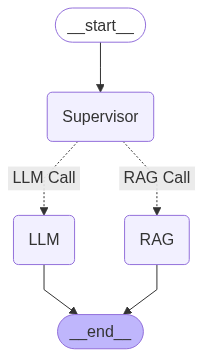

In [21]:
workflow.compile()

In [22]:
app = workflow.compile() 

In [ ]:
state={"messages":["I have mustard, tomatoes, oil , ghee and onions , carrots . What all different food items can i make with ?"]} 

In [ ]:
app.invoke(state) 